Detected object: paragraph, Confidence: 1.00, Box: [298.27444 502.09738 822.8848  775.9231 ]
Detected object: paragraph, Confidence: 1.00, Box: [307.50647 778.76544 822.90894 878.5802 ]
Detected object: paragraph, Confidence: 0.99, Box: [298.1775  380.70135 822.499   504.45633]
Detected object: paragraph, Confidence: 0.99, Box: [  7.5801725  22.49451   303.8064    341.43976  ]
Detected object: image, Confidence: 0.99, Box: [300.75284  40.83902 618.43274 237.07336]
Detected object: image, Confidence: 0.98, Box: [552.42413   28.824986 804.5201   312.4303  ]
Detected object: paragraph, Confidence: 0.96, Box: [306.8592  935.81683 811.82996 988.679  ]
Detected object: title, Confidence: 0.93, Box: [303.16397 896.5524  436.75858 928.89575]
Detected object: image, Confidence: 0.93, Box: [322.4849    33.214943 809.79675  298.6862  ]
Detected object: title, Confidence: 0.78, Box: [600.61224  29.89572 756.43414  45.21474]
Detected object: title, Confidence: 0.71, Box: [741.8632  205.07652 804.24

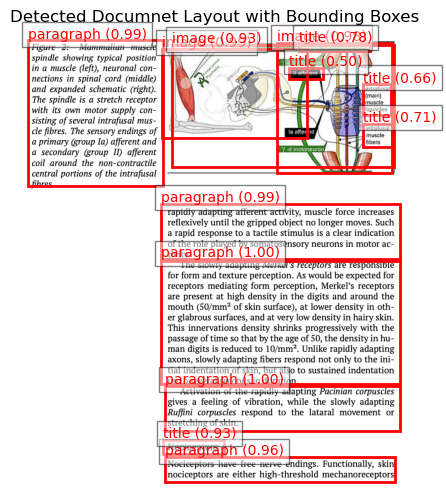

In [27]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the fine-tuned model
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 6  # 5 class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("Document Analysis.pth", map_location=torch.device('cpu')))
model.to("cpu")
model.eval()

# Load test image
test_image_path = "test2.png"  # Replace with your test image path
img = Image.open(test_image_path).convert("RGB")
img_tensor = ToTensor()(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    prediction = model(img_tensor)

# Process predictions
boxes = prediction[0]['boxes'].numpy()
labels = prediction[0]['labels'].numpy()
scores = prediction[0]['scores'].numpy()

# Convert image to numpy array for plotting
img_np = np.array(img)

# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.imshow(img_np)


# Category name map (based on your dataset)
CATEGORY_NAMES = {
    1: "image",
    2: "paragraph",
    3: "table",
    4: "title"
}

# Filter predictions and draw bounding boxes
confidence_threshold = 0.5
for box, label, score in zip(boxes, labels, scores):
    if score > confidence_threshold:
        label_name = CATEGORY_NAMES.get(label, "unknown")

        # Print detection
        print(f"Detected object: {label_name}, Confidence: {score:.2f}, Box: {box}")
        
        # Draw bounding box
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label and score
        label_text = f"{label_name} ({score:.2f})"
        ax.text(x_min, y_min - 5, label_text, color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


# Remove axes for better visualization
ax.axis('off')
plt.title("Detected Documnet Layout with Bounding Boxes")
plt.savefig("output_image_with_boxes.png")  # Save the image
plt.show()